## Analysis of External and Upsampled Metadata for SIIM-ISIC Melanoma Classification
### Introduction

#### This notebook is part of the project I started here: [Analysis of Melanoma Metadata and EffNet Ensemble](https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble), more like complementary work of the tabular part. The main objective of this notebook is using past years competitions data as well as using upsampling with the great datasets uploaded by Chris Deotte [explained here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139), so what we have in this data:

* Image Names, Sex, Age, Anatom Sites, Width/Height of the Images and Targets of:
    * Current 2020 set with 33k examples including 584 malignant examples,
    * 2017/18-2019 set with 25k examples with 4522 malignant examples,
    * 580 completely new malignant examples coming from Chris Deotte's Malignant TFRecords 15-29
    
#### So what are we trying to achieve is getting more solid predictions solely based on metadata, with the help of upsampled data. So we can use these results in our ensembles to get stronger final products for final predictions...

#### I'm gonna try to keep this work as simple as possible and similar to my main work so you can compare them easily.

# Loading the Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import plotly.express as px

import os
import random
import re
import math
import time

import warnings

warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [2]:
# Setting color palette.
black_red = [
    '#1A1A1D', '#4E4E50', '#C5C6C7', '#6F2232', '#950740', '#C3073F'
]

# Setting plot styling.
plt.style.use('fivethirtyeight')

In [3]:
# loading datasets

train = pd.read_csv('../input/melanomaextendedtabular/external_upsampled_tabular.csv')
test = pd.read_csv('../input/melanomaextendedtabular/test_tabular.csv')
sample = pd.read_csv('../input/melanomaextendedtabular/sample_submission.csv')

In [4]:
train.sample(5)

,image_name,sex,age_approx,anatom_site_general_challenge,target,width,height
16731,ISIC_5119261,male,65.0,torso,0,6000,4000
47888,ISIC_0056456,female,80.0,head/neck,0,1024,1024
3570,ISIC_1176987,female,60.0,torso,0,640,480
17136,ISIC_5231616,male,45.0,lower extremity,0,640,480
9911,ISIC_3073634,female,35.0,upper extremity,0,6000,4000


In [5]:
# checking column names

print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations and Test data {test.shape[1]} features, {test.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\nTest features are:\n{test.columns.tolist()}'
)

Train data has 7 features, 58916 observations and Test data 6 features, 10982 observations.
Train features are:
['image_name', 'sex', 'age_approx', 'anatom_site_general_challenge', 'target', 'width', 'height']
Test features are:
['image_name', 'sex', 'age_approx', 'anatom_site_general_challenge', 'width', 'height']


In [6]:
# renaming column names for easier use

train.columns = [
    'img_name',  'sex', 'age', 'location', 'target','width','height'
]

test.columns = ['img_name', 'sex', 'age', 'location','width','height']



# Missing Values

Looks like our external data has some missing values, which is expected. Body part missing numbers increased around three times, missing ages increased about four times and gender missing rates didn't change much but small increase... [2020 values here](https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble#Missing-Values).

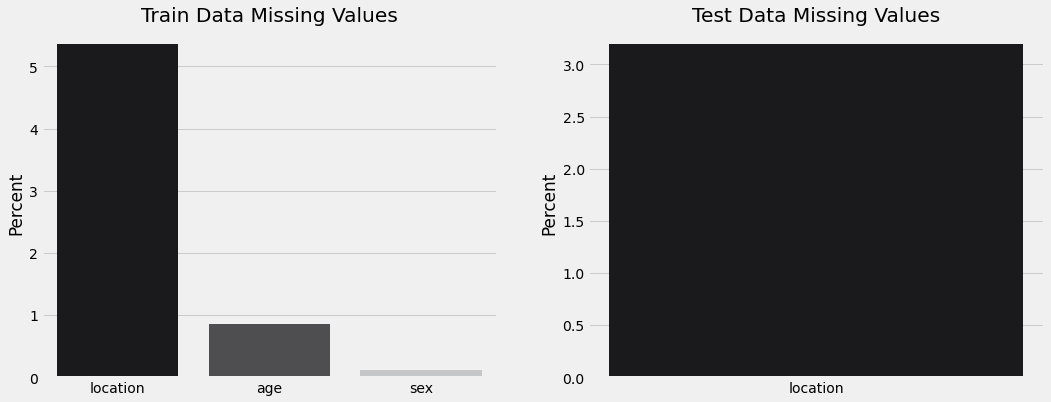

In [7]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=black_red,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=black_red,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

plt.show()

# Distribution Differences

Meanwhile age and gender distributions seems pretty similar with external data anatom site part has some differences: palms/soles, oral/genital and head/neck parts increased a lot in train data we might have to check these further...

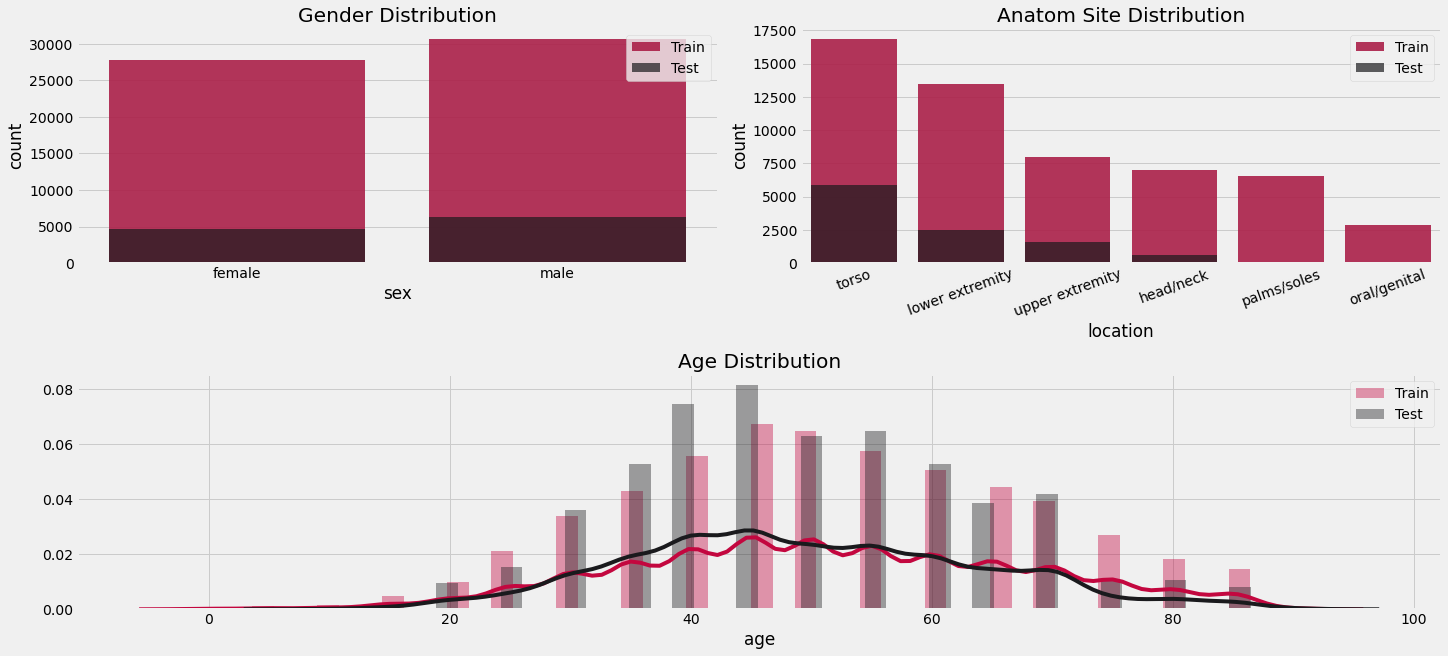

In [8]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#C3073F',
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#1A1A1D',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train.location,
              alpha=0.9,
              ax=ax2,
              color='#C3073F',
              label='Train',
              order=train['location'].value_counts().index)
sns.countplot(test.location,
              alpha=0.7,
              ax=ax2,
              color='#1A1A1D',
              label='Test',
              order=test['location'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()
plt.xticks(rotation=20)

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(train.age, ax=ax3, label='Train', color='#C3073F')
sns.distplot(test.age, ax=ax3, label='Test', color='#1A1A1D')

ax3.legend()

plt.show()

# Imputing Missing Values

This time I decided to replace missing values with fixed values instead of replacing them with most frequent ones, since we have higher miss ratio...

In [9]:
# Filling missing  values with 'unknown' and '-1' tags:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)
    
train['sex'].fillna('unknown', inplace=True)

train['age'].fillna(-1, inplace=True)

# Anatom Site Differences

It seems there are some differences between 2020 data and external data in terms of body part values. Looks like external data has more detailed approach for torso, we can fix that by merging all torso parts to 2020 data version which is torso for all...(Duh!)

In [10]:
# Double checking:

ids_train = train.location.values
ids_test = test.location.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'There are no different body parts occuring between train and test set...'
    )
else:
    print('There are some non-overlapping values between train and test set!\n')
    print(f'Different ones are:\n{pd.Series(np.setdiff1d((train.location.value_counts().index), pd.Series(test.location.value_counts().index)))}')


There are some non-overlapping values between train and test set!

Different ones are:
0     anterior torso
1      lateral torso
2    posterior torso
dtype: object


In [11]:
# merging detailed torso approach to torso only
train.replace(['anterior torso','lateral torso','posterior torso'], 'torso', inplace=True)

# Body Part Ratio by Gender and Target

We have very different malignant ratio for external data it seems. You can check [2020 values here](https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble#Body-Part-Ratio-by-Gender-and-Target). This is big difference but might be useful for unseen test data...

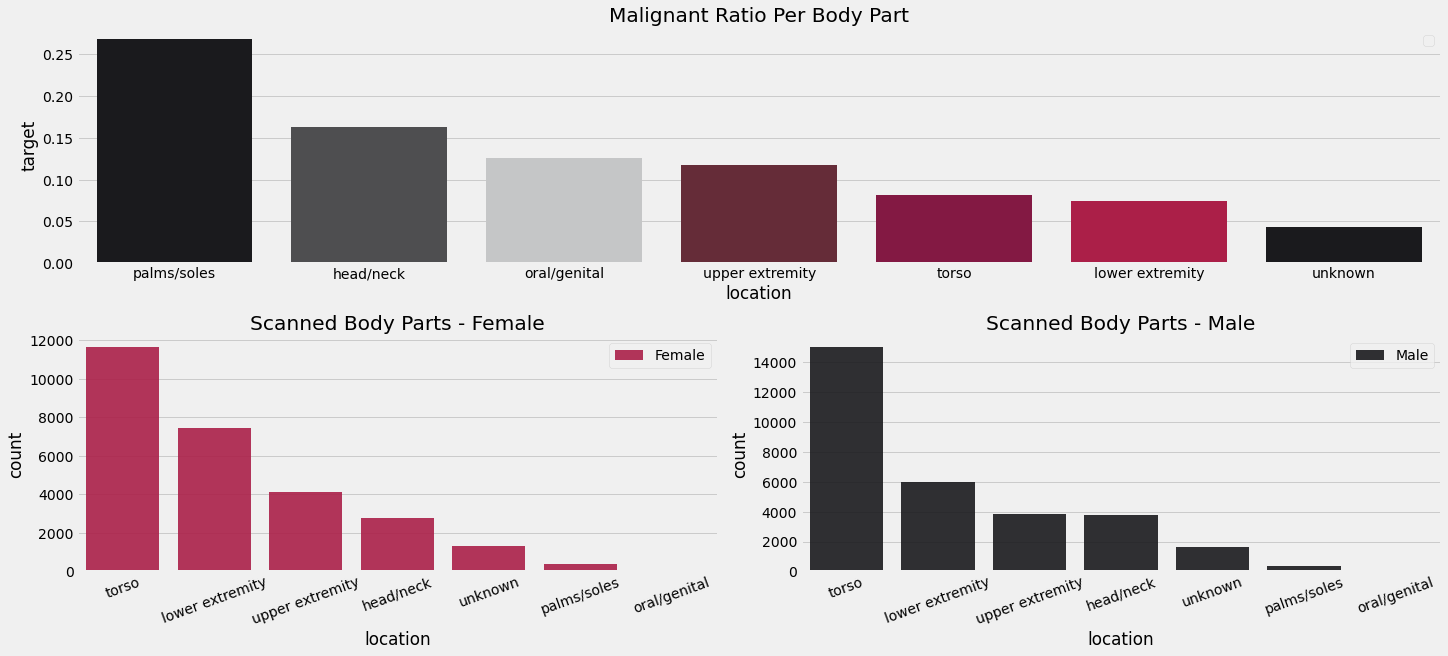

In [12]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[1, :2])
# Set the title.
ax1.set_title('Scanned Body Parts - Female')

# Plot:

sns.countplot(
    train[train['sex'] == 'female'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
    color='#C3073F',
    label='Female',
    order=train['location'].value_counts().index)
ax1.legend()
plt.xticks(rotation=20)

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, 2:])

# Set the title.

ax2.set_title('Scanned Body Parts - Male')

# Plot.

sns.countplot(
    train[train['sex'] == 'male'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    color='#1A1A1D',
    label='Male',
    order=train['location'].value_counts().index)

ax2.legend()
plt.xticks(rotation=20)

# Customizing the third grid.

ax3 = fig.add_subplot(grid[0, :])

# Set the title.

ax3.set_title('Malignant Ratio Per Body Part')

# Plot.

loc_freq = train.groupby('location')['target'].mean().sort_values(
    ascending=False)
sns.barplot(x=loc_freq.index, y=loc_freq, palette=black_red, ax=ax3)

ax3.legend()


plt.show()

# Sunburst Chart


- We almost doubled our malignant examples with upsampling and external data,
- Malignant images became more balanced 56% male to 44% female. It was 62% vs 38% in 2020 data,
- Gender wise benign images has same ratio as 2020,
- Malignant image scan locations differs based on the patients gender:
    - Torso still most common location in males even with 3% decrease; meanwhile female malignant torso scans decreased like 6% with external data,
    - Lower extremity still more common with female scans than males 12% males vs 26% females (it was 18% vs 26% in 2020 data)
    - Again upper extremity malignant scans are more common with females than males with 15% males vs 20% females (used to be 17% - 23%)
    - Head/Neck malignant scans increased with external data on both genders.

In [13]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['target', 'sex', 'location'],
                  color='sex',
                  color_discrete_sequence=black_red,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

# Age and Scan Result Relations

Age distribution seems little bit different with external data added. In general we have older patients, benign scan age distributions seems more closer to each other than 2020 data, meanwhile malignant difference stay at same levels between genders. We can say generally examples which missing gender values are also missing age values too. Lastly we still have age effect on malignant scans with the difference visible on age below 0 because of the imputing method we choose.

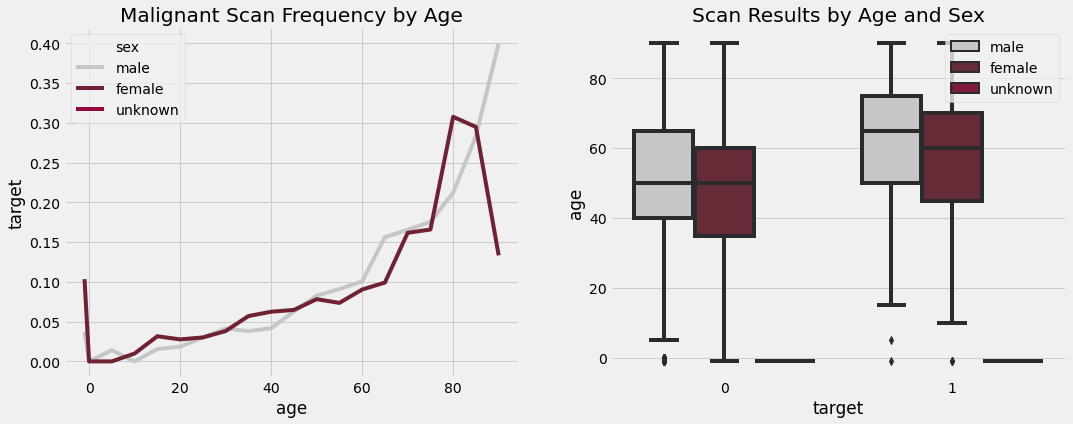

In [14]:
# Plotting age vs sex vs target:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age',
             y='target',
             data=train,
             ax=ax[0],
             hue='sex',
             palette=black_red[2:5],
             ci=None)
sns.boxplot(x='target',
            y='age',
            data=train,
            ax=ax[1],
            hue='sex',
            palette=black_red[2:5]
           )

plt.legend(loc='upper right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

# Age 

Age distribution seems similar with external data, you can [you can compare them here](https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble#Age-Round-Two).

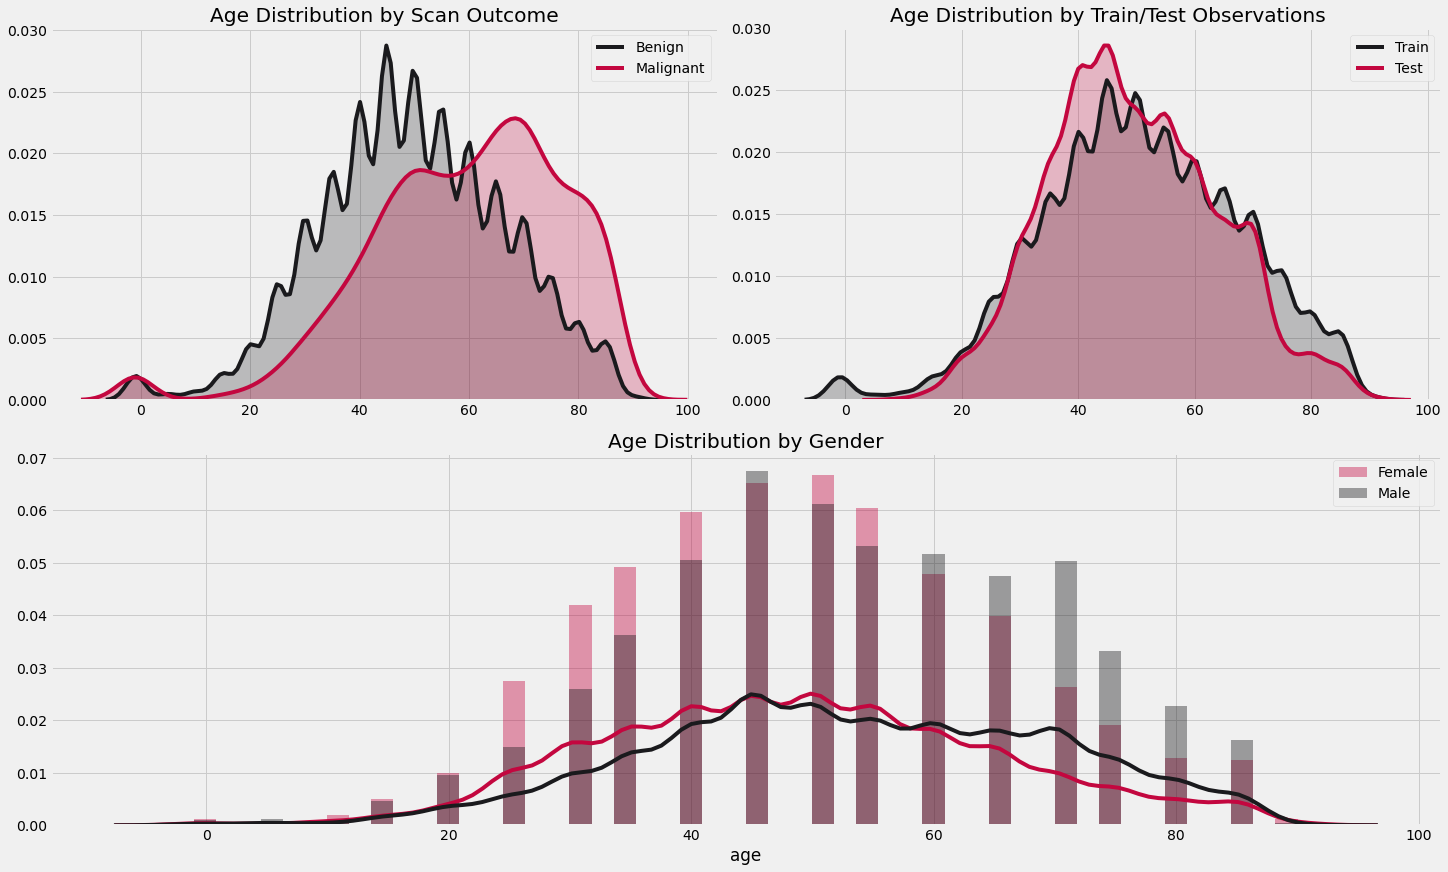

In [15]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Age Distribution by Scan Outcome')

# Plot

ax1.legend()

sns.kdeplot(train[train['target'] == 0]['age'],
            shade=True,
            ax=ax1,
            color='#1A1A1D',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['age'],
            shade=True,
            ax=ax1,
            color='#C3073F',
            label='Malignant')

# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Age Distribution by Train/Test Observations')

# Plot.

sns.kdeplot(train.age, label='Train', shade=True, ax=ax2, color='#1A1A1D')
sns.kdeplot(test.age, label='Test', shade=True, ax=ax2, color='#C3073F')

ax2.legend()

# Customizing third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution by Gender')

# Plot

sns.distplot(train[train.sex == 'female'].age,
             ax=ax3,
             label='Female',
             color='#C3073F')
sns.distplot(train[train.sex == 'male'].age,
             ax=ax3,
             label='Male',
             color='#1A1A1D')
ax3.legend()

plt.show()

# Image Resolutions 

We had decent observations in the previous notebook about image sizes so wanted to check them here with external data again. With the new examples we increased variety of the image sizes (with high number of 1024x1024 images coming in) but we can see 1920x1080 images in test set still seperated, so we should be really careful about image sizes in our models...

In [16]:
# getting temporary resolution feature

train['res']= train['width'].astype(str)+'x'+train['height'].astype(str)
test['res']= test['width'].astype(str)+'x'+test['height'].astype(str)

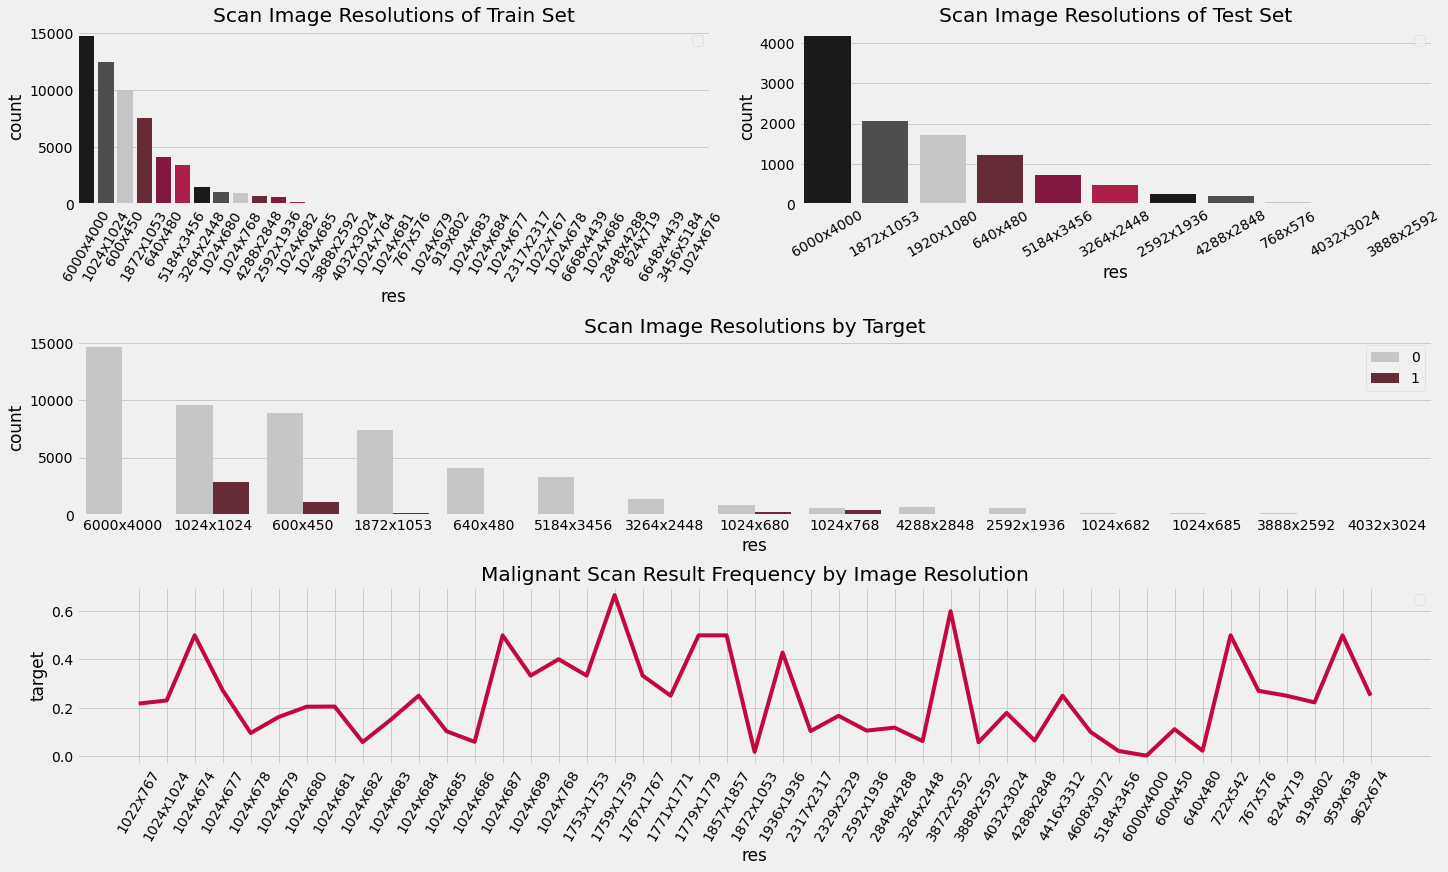

In [17]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Scan Image Resolutions of Train Set')

# Plot.

tres = train.res.value_counts().rename_axis('res').reset_index(name='count')
tres = tres[tres['count'] > 10]
sns.barplot(x='res', y='count', data=tres, palette=black_red, ax=ax1)
plt.xticks(rotation=60)

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Scan Image Resolutions of Test Set')

# Plot

teres = test.res.value_counts().rename_axis('res').reset_index(name='count')
teres = teres[teres['count'] > 10]
sns.barplot(x='res', y='count', data=teres, palette=black_red, ax=ax2)
plt.xticks(rotation=30)
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Scan Image Resolutions by Target')

# Plot.

sns.countplot(x='res',
              hue='target',
              data=train,
              order=train.res.value_counts().iloc[:15].index,
              palette=black_red[2:4],
              ax=ax3)
ax3.legend()

# Customizing the last grid.

ax4 = fig.add_subplot(grid[2, :])

# Set the title.

ax4.set_title('Malignant Scan Result Frequency by Image Resolution')

# Plot.

res_freq = train.groupby('res')['target'].mean()
res_freq = res_freq[(res_freq > 0) & (res_freq < 1)]
sns.lineplot(x=res_freq.index, y=res_freq, color='#C3073F', ax=ax4)
ax4.legend()
plt.xticks(rotation=60)

plt.show()

In [18]:
# getting rid of temporary features

train.drop(['res'], axis=1, inplace=True)
test.drop(['res'], axis=1, inplace=True)

# Modelling the Tabular Data

This part is pretty straight and very similar to work we have in previous notebook. First we get dummies for categorical data and drop redundant ones, then we import neccesary packages, split our data, set model parameters,cross validate and so on...

In [19]:
#creating dummy variables for categorical sex data

sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)

train.drop(['sex'], axis=1, inplace=True)
test.drop(['sex'], axis=1, inplace=True)

In [20]:
# getting dummy variables for location on train set

anatom_dummies = pd.get_dummies(train['location'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)

# getting dummy variables for location on test set

anatom_dummies = pd.get_dummies(test['location'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)

# dropping useless columns

train.drop('location', axis=1, inplace=True)
test.drop(['location'], axis=1, inplace=True)

In [21]:
# dropping redundant columns for both dataset

for df in [train, test]:
    df.drop('img_name', axis=1, inplace=True)

In [22]:
# importing basic modelling stuff

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

In [23]:
# creating train variables

X = train.drop('target', axis=1)
y = train.target

In [24]:
# taking 15% of the training data as holdout

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    stratify=y,
                                                    random_state=42)

# 5 fold stratify for cv

cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [25]:
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...

xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=2,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,
    n_jobs=-1,
)

In [26]:
estimators = [xg]

In [27]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train roc Mean'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Test roc Mean'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test roc Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

# First Results

Hmmm... I feel like there's overfitting, not directly based on cross validation but from the experiences based on past notebook, we should check feature importances and then apply adversarial validation if needed.

In [28]:
# display cv results

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models.style.background_gradient(cmap='twilight', axis=1))

,Model Name,Train roc Mean,Test roc Mean,Test Std,Time
0,XGBClassifier,0.854756,0.852192,0.005487,16.280270


In [29]:
# fitting train data

xg.fit(X_train, y_train)

# predicting on holdout set
validation = xg.predict_proba(X_test)[:, 1]

# checking results on validation set
roc_auc_score(y_test, validation)

0.8504548818145291

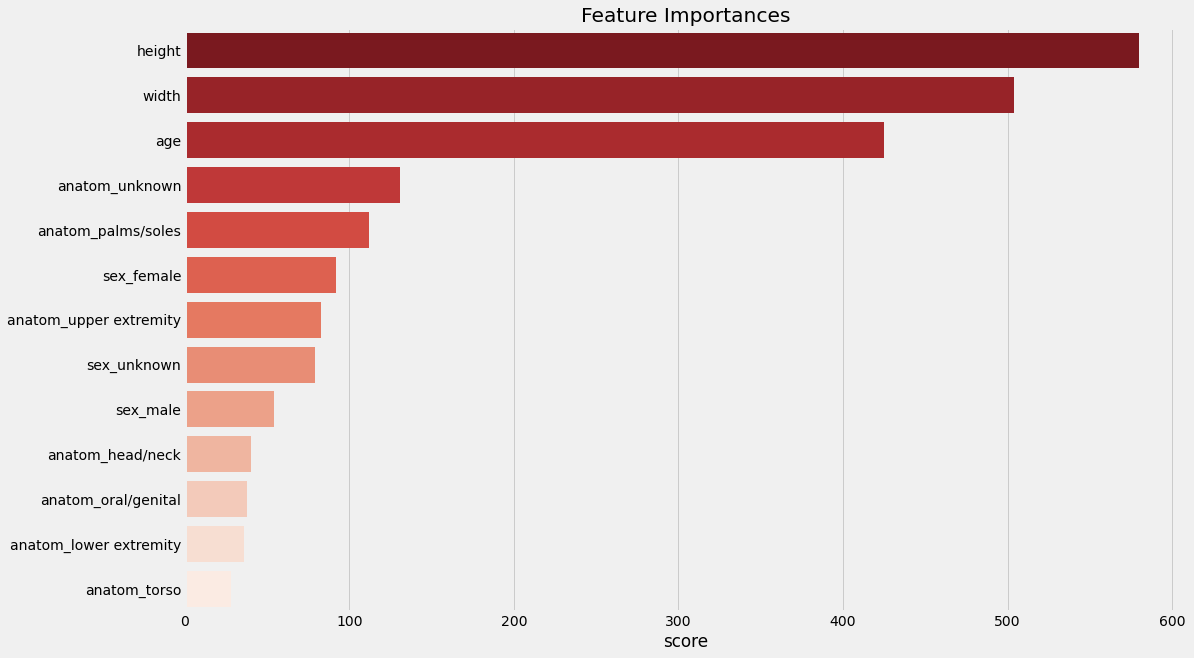

In [30]:
# finding feature importances and creating new dataframe basen on them

feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importances')
plt.show()

# Adversarial Validation

Just quoting from the previous notebook:

> Alright, since we have high doubts for train test sampling wanted to implement what is called 'Adversarial Validation'. For this we going to replace our targets for both datasets (0 for train and 1 for test), then we going build a classifier which tries to predict which observation belongs to train and which one belongs to test set. If datasets randomly selected from similar roots it should be really hard for the classifier to separate them. But if there is systematic selection differences between train and test sets then classifier should be able to capture this trend. So we want our models score lower for the next section because higher detection rate means higher difference between train and test datasets, so let's get started...



In [31]:
# creating adversarial training set

adv_train = train.copy()
adv_train.drop('target', axis=1, inplace=True)
adv_test = test.copy()

adv_train['dataset_label'] = 0
adv_test['dataset_label'] = 1

adv_master = pd.concat([adv_train, adv_test], axis=0)

adv_X = adv_master.drop('dataset_label', axis=1)
adv_y = adv_master['dataset_label']

In [32]:
# holdout set for adv

adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(adv_X,
                                                    adv_y,
                                                    test_size=0.4,
                                                    stratify=adv_y,
                                                    random_state=42)

In [33]:
xg_adv = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
)

# Fitting train data

xg_adv.fit(adv_X_train, adv_y_train)

# Predicting on holdout set
validation = xg_adv.predict_proba(adv_X_test)[:,1]

In [34]:
def plot_roc_feat(y_trues, y_preds, labels, est, x_max=1.0):
    
    """ A function for displaying roc/auc curve and feature importances. """
    
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax[0].plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax[0].legend()
    ax[0].grid()
    ax[0].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax[0].set_title('ROC curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_xlim([-0.01, x_max])
    _ = ax[0].set_ylabel('True Positive Rate')
    
    
    feature_importance = est.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
    
    sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette=black_red, ax=ax[1])
    ax[1].set_title('Feature Importances')

# Validation Results

Wow... So with the help of "sex_unknown", "height" and "width" features our model perfectly predicted what data is coming from external train data or original test set. We should take care of these and see if it helps...

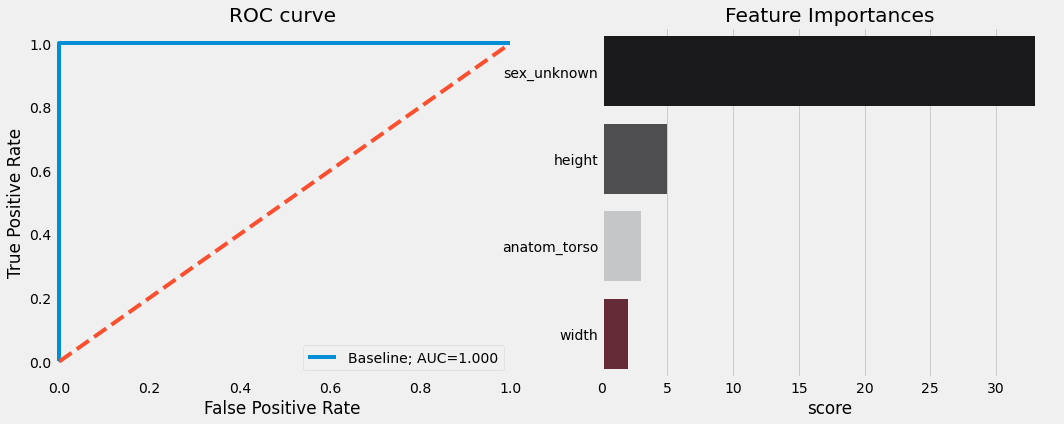

In [35]:
plot_roc_feat(
    [adv_y_test],
    [validation],
    ['Baseline'],
    xg_adv
)

In [36]:
# dropping features for better randomness

adv_X.drop(['sex_unknown', 'height', 'width'], axis=1, inplace=True)


adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(adv_X,
                                                    adv_y,
                                                    test_size=0.4,
                                                    stratify=adv_y,
                                                    random_state=42)

# fitting train data

xg_adv.fit(adv_X_train, adv_y_train)

# predicting on holdout set
validation = xg_adv.predict_proba(adv_X_test)[:,1]

# Validation Without Some Features

So when we drop these features highly important on seperating train and test set we got much random results, maybe it's not perfect but seems something we can work with...

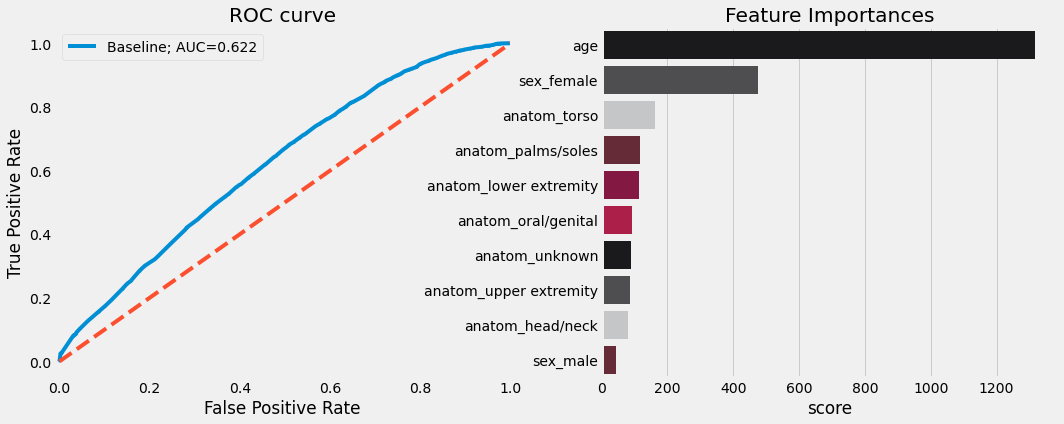

In [37]:
plot_roc_feat(
    [adv_y_test],
    [validation],
    ['Baseline'],
    xg_adv
)

In [38]:
# dropping features from original train set

X_train.drop(['sex_unknown', 'width','height'], axis=1, inplace=True)

test.drop(['width','height'], axis=1, inplace=True)

In [39]:
# setting parameters

xg= xgb.XGBClassifier(
    n_estimators=750,
    learning_rate=0.015,
    min_child_weight= 59,
    max_delta_step= 6,
    max_depth= 6,
    subsample= 0.751,
    colsample_bytree= 0.8595,
    gamma= 0,
    reg_lambda= 37,
    random_state=42,
    n_jobs=-1,
)

# Simplified Version of the Extended Tabular Results

Alright! Without the distinctive features we lost some auc score but I feel it's much more regularized and can be used for our testing predictions plus ensembles...

In [40]:
# display cv results

raw_models = model_check(X_train, y_train, [xg], cv)
display(raw_models.style.background_gradient(cmap='twilight', axis=1))

,Model Name,Train roc Mean,Test roc Mean,Test Std,Time
0,XGBClassifier,0.710599,0.703897,0.007652,31.995916


In [41]:
# fitting and predicting

xg.fit(X_train, y_train)

predictions = xg.predict_proba(test)[:, 1]

meta_df = pd.DataFrame(columns=['image_name', 'target'])

# assigning predictions on submission df

meta_df['image_name'] = sample['image_name']
meta_df['target'] = predictions

# creating submission csv file

meta_df.to_csv('external_tabular_predicts.csv', header=True, index=False)

# Ensemble and Submit

We don't need to run whole model again here so I'm going to load EffNet predictions from previous [notebook here](https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble#Machine-Learning-to-Neural-Networks).

In [42]:
# loading predictions from csv file and ensemble them

effnet = pd.read_csv('../input/blended-effnets-from-previous-notebook/blended_effnets.csv')
meta = pd.read_csv('./external_tabular_predicts.csv')


sample['target'] = (
                           
                           effnet['target'] * 0.9 +
                           meta['target'] * 0.1 
                          
                          )

sample.to_csv('external_meta_ensembled.csv', header=True, index=False)

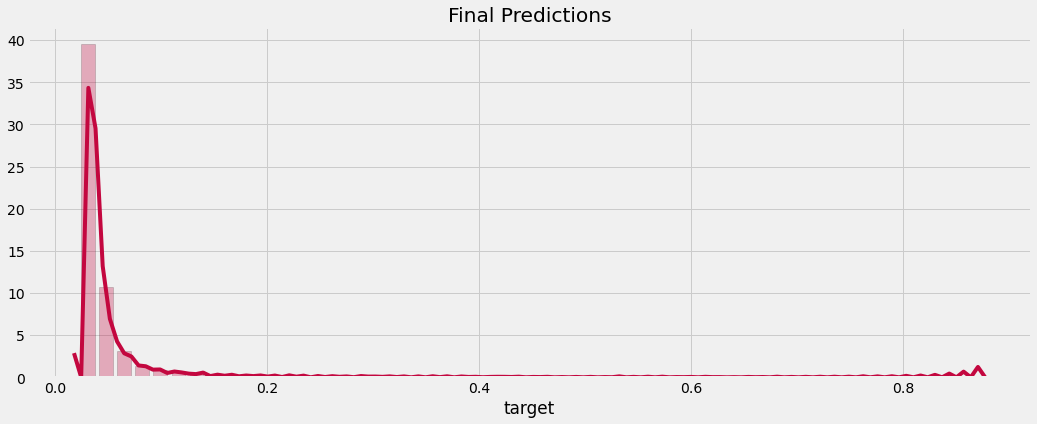

In [43]:
# display auc distribution

fig, ax = plt.subplots(figsize=(16,6))
sns.distplot(sample['target'], hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             }, color='#C3073F')
ax.set_title('Final Predictions')
plt.show()

# Final Words

### This ensembling increased my public LB score by small margin in my private tests compared to previous 2020 meta blend. I hope it works for you too!

#### Again this is complementary work of the what I started at [Analysis of Melanoma Metadata and EffNet Ensemble](https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble), I didn't want to pile it on with more EDA and modelling again, hope it helps you as much as it did to me! I'm open to feedbacks so you can leave a comment if you like and if you enjoyed my work it please don't forget to vote, happy coding!